In [1]:
import numpy as np
import awkward as ak
import fastjet
import uproot as ur
import matplotlib.colors as mcolors
import mplhep as hep
import matplotlib.pyplot as plt
import math
import matplotlib as colors
import matplotlib as abc
from scipy.optimize import curve_fit
import pandas as pd
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle

hep.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
antiktR = 0.5
minDR = 0.25
input_file_data = 'SmallData.root'
input_file_sim = 'pythia6Reco.root'

In [3]:
def eta(r, z):
    theta = abs(np.arctan(r / z))
    result = np.where(z < 0, np.log(np.tan(theta / 2)), -1 * np.log(np.tan(theta / 2)))
    return result

def phi(x,y):
    return np.arctan2(y, x)

def momentum_xyz(px, py, pz):
    norm = np.sqrt(px**2 + py**2 + pz**2)
    x = px / norm
    y = py / norm
    z = pz / norm
    return x, y, z

def jet_dict(px, py, pz, e, minE, cuts):
    momenta = ak.zip(
    {
        "px": ak.Array(px),
        "py": ak.Array(py),
        "pz": ak.Array(pz),
        "E": ak.Array(e),
    }
    )
    lorentz = ak.Array(momenta, with_name="Momentum4D", behavior=ak.behavior)
    
    # Define the jet definition
    jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, antiktR)

    # Cluster the particles into jets
    cluster = fastjet.ClusterSequence(lorentz, jetdef)
    inc_jets = cluster.inclusive_jets()
    x, y, z = momentum_xyz(inc_jets.px, inc_jets.py, inc_jets.pz)
    jeta = eta(np.sqrt(x**2 + y**2), z)
    jetXE = 724 * x / z
    jetYE = 724 * y / z
    buffer = 20
    #x between -146.85802 and -27.032663, pos
    #y between -93.104996 and 96.704994
    #Granularity = 10
    cut_secondary = (inc_jets.E >= minE) & (((jetXE >= (-146.85802 + buffer)) &  (jetXE <= (-27.032663 - buffer))) | ((jetXE <= (146.85802 - buffer)) &  (jetXE >= (27.032663 + buffer)))) & (jetYE >= (-93.104996 + buffer)) & (jetYE <= (96.704994 - buffer))
    #cut_secondary = (inc_jets.E >= minE)
    etaMin = 2.5
    etaMax = 3.5
    #etaMin = 0
    if(not cuts):
        cut_secondary = (inc_jets.E >= minE) & (jeta >= etaMin) & (jeta <= etaMax)
    #cut_secondary = (inc_jets.E >= minE) & (jeta >= etaMin) & (jeta <= etaMax)
    data_dict = {
        "energy": inc_jets.E[cut_secondary],
        "eta": jeta[cut_secondary],
        "phi": phi(x[cut_secondary], y[cut_secondary]),
    }
    return data_dict

In [4]:

events = ur.open("%s:data"%(input_file_data))
arrays = events.arrays()

posx = arrays['Cal_hit_posx']
posy = arrays['Cal_hit_posy']
posz = arrays['Cal_hit_posz']
energy = arrays['Cal_hit_energy']
detid = arrays['Cal_detid']

adcsum = arrays['Cal_adcsum']
detid = arrays['Cal_detid']

cut_primary = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==0) ^(arrays['Cal_detid']==1) ^ (arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_HCAL = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_ECAL = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==0) ^ (arrays['Cal_detid']==1))

xcut = posx[cut_primary]
ycut = posy[cut_primary]
zcut = posz[cut_primary]
ecut = energy[cut_primary]

xHcal = np.array(ak.flatten(posx[cut_HCAL]))
yHcal = np.array(ak.flatten(posy[cut_HCAL]))
zHcal = np.array(ak.flatten(posz[cut_HCAL]))
eHcal = np.array(ak.flatten(energy[cut_HCAL]))

xEcal = np.array(ak.flatten(posx[cut_ECAL]))
yEcal = np.array(ak.flatten(posy[cut_ECAL]))
zEcal = np.array(ak.flatten(posz[cut_ECAL]))
eEcal = np.array(ak.flatten(energy[cut_ECAL]))

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [ ]:
events = ur.open("%s:data"%(input_file_sim))
arrays = events.arrays()

posx = arrays['Cal_hit_posx']
posy = arrays['Cal_hit_posy']
posz = arrays['Cal_hit_posz']
energy = arrays['Cal_hit_energy']
detid = arrays['Cal_detid']

adcsum = arrays['Cal_adcsum']
detid = arrays['Cal_detid']

cut_primary = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==0) ^(arrays['Cal_detid']==1) ^ (arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_HCAL = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_ECAL = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==0) ^ (arrays['Cal_detid']==1))

xcut = posx[cut_primary]
ycut = posy[cut_primary]
zcut = posz[cut_primary]
ecut = energy[cut_primary]

sxHcal = np.array(ak.flatten(posx[cut_HCAL]))
syHcal = np.array(ak.flatten(posy[cut_HCAL]))
szHcal = np.array(ak.flatten(posz[cut_HCAL]))
seHcal = np.array(ak.flatten(energy[cut_HCAL]))

sxEcal = np.array(ak.flatten(posx[cut_ECAL]))
syEcal = np.array(ak.flatten(posy[cut_ECAL]))
szEcal = np.array(ak.flatten(posz[cut_ECAL]))
seEcal = np.array(ak.flatten(energy[cut_ECAL]))

In [5]:
print(zHcal)
print(zEcal)

[804.1527  807.4703  807.4703  ... 806.5655  806.5655  806.26385]
[724.5681 724.3999 724.3999 ... 724.7363 724.3999 724.7363]


Text(0, 1, 'Y [cm]')

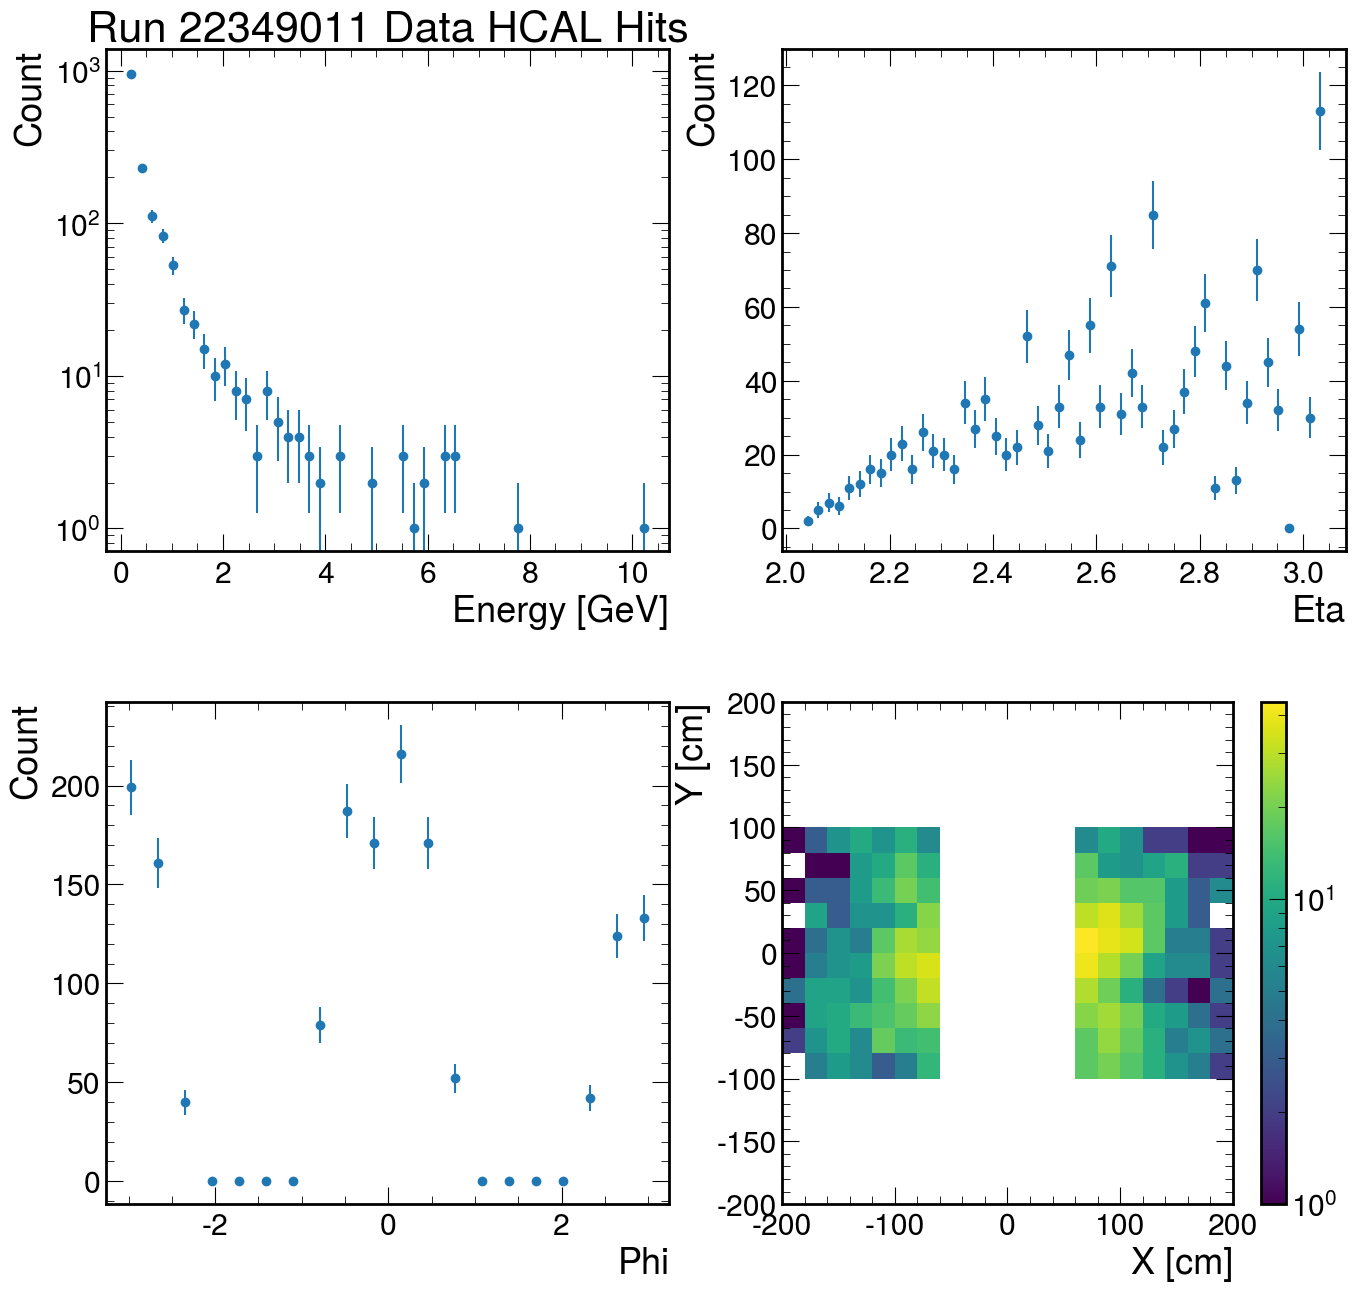

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 15), gridspec_kw={'hspace': 0.3})
R=0.4
plt.sca(axs[0][0])

hist, bin_edges = np.histogram(eHcal,bins=50)

   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.xlabel("Energy [GeV]")
plt.ylabel("Count")
plt.yscale("log")
plt.title("Run 22349011 Data HCAL Hits")

plt.errorbar(np.array(bin_centres), np.array(hist), yerr=np.sqrt(hist),fmt="o")

plt.sca(axs[0][1])

etaHcal = eta(np.sqrt(xHcal**2 + yHcal**2), 806)

hist, bin_edges = np.histogram(etaHcal,bins=50)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.xlabel("Eta")
plt.ylabel("Count")


plt.errorbar(np.array(bin_centres), np.array(hist), yerr=np.sqrt(hist),fmt="o")

plt.sca(axs[1][0])

phiHcal = phi(xHcal, yHcal)

hist, bin_edges = np.histogram(phiHcal,bins=20)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.xlabel("Phi")
plt.ylabel("Count")


plt.errorbar(np.array(bin_centres), np.array(hist), yerr=np.sqrt(hist),fmt="o")

plt.sca(axs[1][1])
plt.hist2d(xHcal,yHcal,bins=(20,20),range=([-200,200],[-200,200]),cmap='viridis',norm=abc.colors.LogNorm())
cbar = plt.colorbar()
plt.xlabel("X [cm]")
plt.ylabel("Y [cm]")

Text(0, 1, 'Y [cm]')

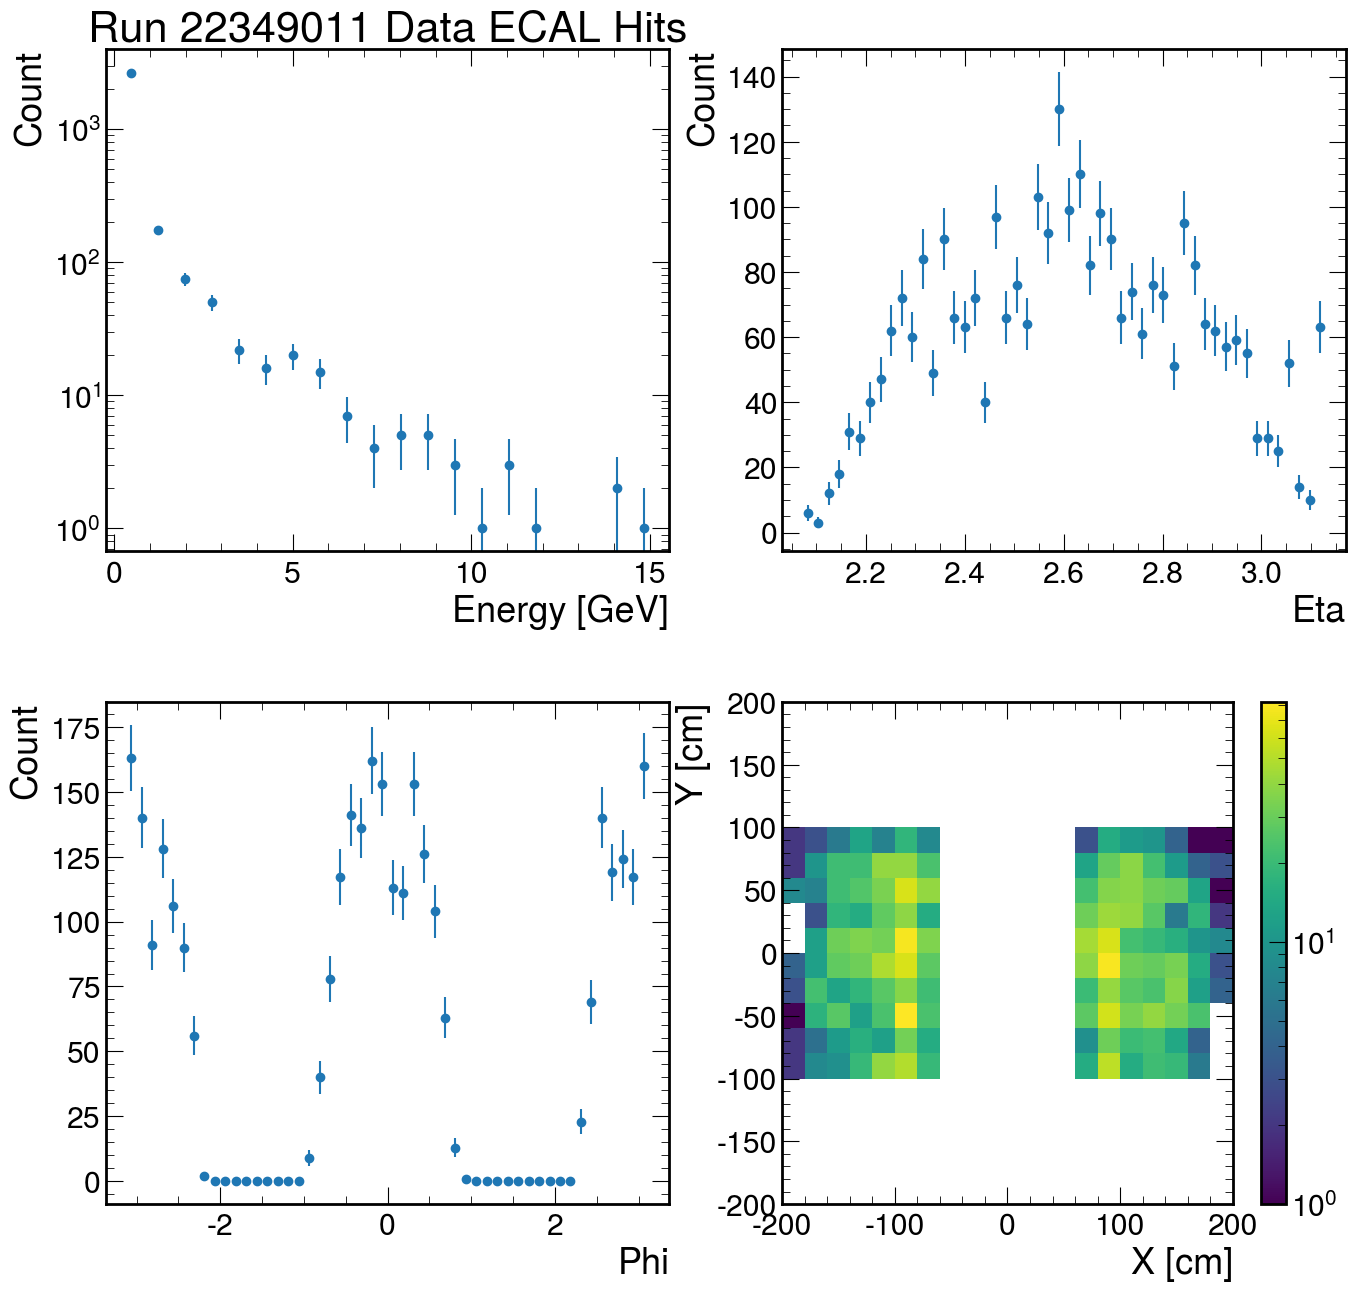

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 15), gridspec_kw={'hspace': 0.3})
R=0.4
plt.sca(axs[0][0])

hist, bin_edges = np.histogram(eEcal,bins=20)

   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.xlabel("Energy [GeV]")
plt.ylabel("Count")
plt.yscale("log")
plt.title("Run 22349011 Data ECAL Hits")

plt.errorbar(np.array(bin_centres), np.array(hist), yerr=np.sqrt(hist),fmt="o")

plt.sca(axs[0][1])

etaEcal = eta(np.sqrt(xEcal**2 + yEcal**2), 806)

hist, bin_edges = np.histogram(etaEcal,bins=50)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.xlabel("Eta")
plt.ylabel("Count")


plt.errorbar(np.array(bin_centres), np.array(hist), yerr=np.sqrt(hist),fmt="o")

plt.sca(axs[1][0])

phiEcal = phi(xEcal, yEcal)

hist, bin_edges = np.histogram(phiEcal,bins=50)
   
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.xlabel("Phi")
plt.ylabel("Count")


plt.errorbar(np.array(bin_centres), np.array(hist), yerr=np.sqrt(hist),fmt="o")


plt.sca(axs[1][1])
plt.hist2d(xEcal,yEcal,bins=(20,20),range=([-200,200],[-200,200]),cmap='viridis',norm=abc.colors.LogNorm())
cbar = plt.colorbar()
plt.xlabel("X [cm]")
plt.ylabel("Y [cm]")

In [9]:
print(len(reco_dict["energy"]))

100


In [10]:
with open('Run22349011_R_0.5_dR_0.25.pickle', 'wb') as handle:
    pickle.dump(reco_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)